# Figures

To plot the figures in OSR10 paper by Fernandez-Alvarez et al. (2026)

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats as stats
import cmocean
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from adjustText import adjust_text
from matplotlib.gridspec import GridSpec

import sys
sys.path.append('/home/bfernandez/Escritorio/MHW/Estadistica')
import blanca_tools         as btools

In [ ]:
root_fold = "/home/bfernandez/Escritorio/OSR10/results"
savefold = "/home/bfernandez/Escritorio/OSR10/figures"
baselines = ['fixed_baseline', 'moving_baseline', 'detrended_baseline']
titles = ['Fixed', 'Moving', 'Detrended']

In [ ]:
fold = "/home/bfernandez/Escritorio/OSR10/data/SST/"
files = btools.dirtodict(fold)[".files"]
ds = xr.open_mfdataset(files, combine="by_coords")
harmonics = xr.open_mfdataset('/home/bfernandez/Escritorio/OSR10/harmonics_trends/harmonic_results_combined.nc')
residuals = xr.open_mfdataset('/home/bfernandez/Escritorio/OSR10/harmonics_trends/residuals_combined.nc')
detrended = xr.open_mfdataset('/home/bfernandez/Escritorio/OSR10/sst_detrended.nc', chunks={'time': 100})
# harmonics_mean = xr.open_mfdataset('/home/bfernandez/Escritorio/OSR10/harmonics_trends/harmonic_analysis_mean.nc')
sst = ds['analysed_sst'] - 273.15
sst = sst.astype('float32')
error = ds['analysis_error']
residuals = residuals['residuals']

In [ ]:
ds

<xarray.Dataset> Size: 67GB
Dimensions:         (time: 15706, lat: 317, lon: 837)
Coordinates:
  * lat             (lat) float32 1kB 30.12 30.18 30.23 ... 45.87 45.92 45.97
  * lon             (lon) float32 3kB -5.563 -5.513 -5.463 ... 36.17 36.22 36.27
  * time            (time) datetime64[ns] 126kB 1982-01-01 ... 2024-12-31
Data variables:
    analysed_sst    (time, lat, lon) float64 33GB dask.array<chunksize=(365, 317, 837), meta=np.ndarray>
    analysis_error  (time, lat, lon) float64 33GB dask.array<chunksize=(365, 317, 837), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                CF-1.4 
    DSD_entry_id:               -GOS-L4HRfnd-MED
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Scaling_Equation:           (scale_factor*data) + add_offset
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    ...                         ...
    time_coverage_end:          20240928T070000Z
    time_coverage_start:        20240927T190000Z
    title:                      Mediterranean Sea SST Analysis L4, Reprocesse...
    uuid:                       5f7c8b36-978e-11ef-bda8-005056be6f27
    westernmost_longitude:      -18.125
    copernicusmarine_version:   1.3.4

<xarray.DataArray 'analysed_sst' (year: 43)> Size: 172B
dask.array<mean_agg-aggregate, shape=(43,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 344B 1982 1983 1984 1985 1986 ... 2021 2022 2023 2024


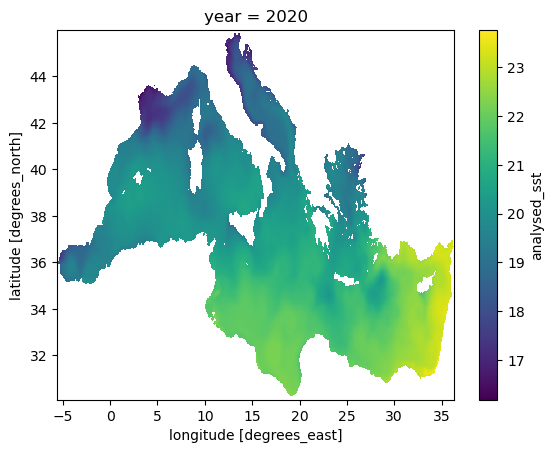

In [ ]:
sst_annual = sst.groupby('time.year').mean(dim='time')
sst_annual.sel(year=2020).plot()
sst_annual_ts = sst_annual.mean(dim=('lat', 'lon'))
print(sst_annual_ts)

In [ ]:
# Define the Mediterranean regions
locations = {
    'WEST_MED': [  # Western Mediterranean
        {'lat': slice(34, 38), 'lon': slice(-5.6, -0.99999)},  # Alboran Sea
        {'lat': slice(35, 46), 'lon': slice(-1, 8.99999)},   # Western Mediterranean
        {'lat': slice(42, 46), 'lon': slice(9, 12)},   # Northern WMED
        {'lat': slice(37, 41.9999), 'lon': slice(9, 14.9999)},   # Tyrrhenian Sea (West)
        {'lat': slice(38.2, 40.5), 'lon': slice(15, 16.1)}  # Tyrrhenian Sea (East)
    ],
    'EAST_MED': [  # Central + Eastern Mediterranean
        # Central Mediterranean (Ionian & Adriatic)
        {'lat': slice(30.1, 36.9999), 'lon': slice(10, 22)},  # Ionian Sea (South)
        {'lat': slice(37, 38.1999), 'lon': slice(15, 22)},  # Ionian Sea (Middle)
        {'lat': slice(38.2, 40.4999), 'lon': slice(16.1, 17.9999)},  # Ionian Sea (North)
        {'lat': slice(38.2, 40), 'lon': slice(18, 22)},  # Ionian Sea (East)
        {'lat': slice(42, 46), 'lon': slice(12, 20)},  # Adriatic Sea (North)
        {'lat': slice(40.5, 41.9999), 'lon': slice(15, 17.9999)},  # Adriatic Sea (Central)
        {'lat': slice(40, 42), 'lon': slice(18, 20)},  # Adriatic Sea (South)
        # Eastern Mediterranean (Levantine & Aegean)
        {'lat': slice(30.1, 35.1999), 'lon': slice(22, 28)},  # Levantine Sea (West)
        {'lat': slice(30.1, 38), 'lon': slice(28.0001, 36.3)},  # Levantine Sea (East)
        {'lat': slice(35.2, 42), 'lon': slice(22, 28)}  # Aegean Sea
    ]
}

Functions to plot:

In [ ]:
# Function to load region data
def load_region_data(sst, locations):
    dss = {}
    for loc_name, coords_list in locations.items():
        region_data = [sst.sel(**coord) for coord in coords_list]
        dss[loc_name] = xr.concat(region_data, dim='lat')
    return dss

## Alternative function to merge boxes
# This function merges multiple lat/lon slices into a single dataset
def merge_boxes(ds, coord_slices):
    """
    Return ds cropped to the union of all lat/lon slices in coord_slices.
    """
    masks = []
    for coords in coord_slices:
        lat0, lat1 = coords['lat'].start, coords['lat'].stop
        lon0, lon1 = coords['lon'].start, coords['lon'].stop
        mask = ((ds.lat >= lat0) & (ds.lat <= lat1) &
                (ds.lon >= lon0) & (ds.lon <= lon1))
        masks.append(mask)
    union_mask = xr.concat(masks, dim="box").any(dim="box")
    ds_union = ds.where(union_mask, drop=True)
    return ds_union

def load_sst_data_for_regions(ds, locations):
    """
    Inputs:
      - ds:        xarray.Dataset(time, lat, lon, ...)
      - locations: dict of {loc_name: [ {lat:slice, lon:slice}, ... ]}
    Returns:
      - out:       dict of {loc_name: xr.Dataset(time, lat, lon, ...)}
    """
    out = {}
    for loc, boxes in locations.items():
        ds_union = merge_boxes(ds, boxes)
        out[loc] = ds_union
    return out

# Function to calculate trend
def trend(sst):
    time_index = np.arange(sst.time.size)
    avg_slope, avg_p_value, avg_intercept, avg_se = btools.mk_test(sst)
    _, _, lo, hi = stats.theilslopes(sst.values.flatten(), time_index, 0.95)
    trend = avg_intercept + avg_slope * time_index
    return trend, avg_slope, avg_se, lo, hi

def trend_b(sst):
    # Accept both DataArray and ndarray
    if hasattr(sst, "time"):
        time_index = np.arange(sst.time.size)
    else:
        time_index = np.arange(len(sst))

    avg_slope, avg_p_value, avg_intercept, avg_se = btools.mk_test(sst)
    _, _, lo, hi = stats.theilslopes(sst.values.flatten(), time_index, 0.95)
    trend = avg_intercept + avg_slope * time_index
    return trend, avg_slope, avg_se, lo, hi

In [ ]:
# --- Helper functions ---
def add_gridlines(ax, label_top=False, label_right=False):
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = label_top
    gl.right_labels = label_right
    return gl

def setup_map(ax, coords=True):
    ax.add_feature(cfeature.LAND, facecolor='white', zorder=2)
    ax.coastlines(zorder=3)
    if coords==True:
        add_gridlines(ax)
    return ax
def precompute_region_stats(dss, window=365):
    """Compute the rolling mean, standard deviation and trend for each region ahead of plotting."""
    stats = {}
    for region, dss_loc in dss.items():
        mean_sst = dss_loc.mean(dim=['lat', 'lon']).rolling(time=window, center=True).mean().load()
        n = len(sst)
        std_sst = sst.std(dim=['lat', 'lon'])
        se_sst = std_sst / np.sqrt(n)
        se_sst = se_sst.rolling(time=window, center=True).mean()

        trend_line, avg_slope, avg_se, lo, hi = trend(mean_sst)
        stats[region] = {
            'mean': mean_sst,
            'std': std_sst,
            'se_sst': se_sst,
            'ci_trend': (lo, hi),
            'trend_line': trend_line,
            'avg_slope': avg_slope,
            'avg_se': avg_se
        }
    return stats

def plot_regions(ax, region_stats, dss_err, region_colors):
    """Plot precomputed region statistics on the given axis."""
    region_labels = {"WEST_MED": "WMed", "CENTRAL_MED": "CMed", "EAST_MED": "EMed"}
    for region, stats in region_stats.items():
        mean_sst = stats['mean']
        # std_sst = stats['std']
        trend_line = stats['trend_line']
        avg_slope = stats['avg_slope']
        avg_se = stats['avg_se']
        # se_sst = stats['se_sst']
        ci_lo, ci_high = stats['ci_trend']
        error = dss_err[region]
        label = f"{region_labels.get(region, region)} Trend {avg_slope*365.25:.3f} ± {avg_se*365.25:.3f} °C/year"
        
        ax.plot(mean_sst.time, mean_sst, label=label,
                color=region_colors[region], alpha=0.7)
        ax.fill_between(mean_sst.time,
                        trend_line - ci_lo, trend_line + ci_high,
                        color=region_colors[region], alpha=0.2)
        ax.plot(mean_sst.time, trend_line, linestyle='--',
                linewidth=2, color=region_colors[region], zorder=3)
    
    ax.set_xlabel("Time")
    ax.set_ylabel("SST (°C)")
    ax.legend()


## Precompute data for Figure 1

The top panel shows the cellwise SST trend, calculated by deseasonalizing the data using harmonic analysis and least squares, then applying the Mann-Kendall test. The slope shown is the Theil-Sen estimator.

The lower panels (time series) are created by first averaging SST over each region (global on the left, regional on the right). A 365-day rolling mean is applied to these regional averages, and the trend is estimated using the Mann-Kendall test and Theil-Sen slope.

In [ ]:
# Precompute stuff for the plot
weighted_mean_sst = btools.weighted_mean(sst).rolling(time=365, center=True).mean()
sst_spatial_mean = btools.weighted_mean(sst)
weighted_mean_error = btools.weighted_mean(error).rolling(time=365, center=True).mean()
n = len(sst)
std_sst = sst.std(dim=['lat', 'lon'])
se_sst = std_sst / np.sqrt(n)
ci_sst = 1.96 * se_sst
ci_sst = ci_sst.rolling(time=365, center=True).mean()
se_sst = se_sst.rolling(time=365, center=True).mean()

'''
# For a 95% confidence interval, we have 2.5% in each tail.
# Get the z-value corresponding to the 97.5th percentile (0.975)
z_value = norm.ppf(0.975)

# Calculate the lower and upper bounds of the confidence interval
ci_lower = mean_sst - z_value * sem
ci_upper = mean_sst + z_value * sem
'''
#Calculate the 2024 anomalies from a 1982-2024 climatology
climatology = sst.sel(time=slice("1982", "2024")).mean(dim="time")
anomalies = sst.sel(time="2024") - climatology


# Calculate the trend
trend_line_w, avg_slope_w, avg_se_w, _, _ = trend(weighted_mean_sst)

dss = load_region_data(sst, locations)
dss_with_new_merge = load_sst_data_for_regions(sst, locations)
dss_err = load_region_data(error, locations)

for region, dss_loc in dss_err.items():
    dss_err[region] = dss_loc.mean(dim=['lat', 'lon']).rolling(time=365, center=True).mean()

region_stats_new = precompute_region_stats(dss_with_new_merge, window=365)
region_stats = precompute_region_stats(dss, window=365)
num_regions = len(locations)
palette = sns.color_palette("CMRmap", num_regions)
region_colors = {loc: col for loc, col in zip(locations.keys(), palette)}

/home/bfernandez/miniconda3/envs/MHWp3.11/lib/python3.11/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(
/home/bfernandez/miniconda3/envs/MHWp3.11/lib/python3.11/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/home/bfernandez/miniconda3/envs/MHWp3.11/lib/python3.11/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/home/bfernandez/miniconda3/envs/MHWp3.11/lib/python3.11/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(
/home/bfernandez/miniconda3/envs/MHWp3.11/lib/python3.11/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/home/bfernandez/miniconda3/envs/MHWp3.11/lib/python3.11/site-packages/dask/array/core.py:

In [ ]:
#Calculate the 2024 anomalies from a 1982-2024 climatology
print("climatology from 1982 to 2024...")
climatology = sst.sel(time=slice("1982", "2024")).mean(dim="time")
print(f'Mean climatology: {float(climatology.mean(dim=["lat", "lon"]).compute()):.3f}°C')
anomalies = sst.sel(time="2024").mean(dim="time") - climatology
print(
    f"2024 anomaly min: {float(anomalies.min().compute()):.3f} °C, "
    f"max: {float(anomalies.max().compute()):.3f} °C, "
    f"mean: {float(anomalies.mean().compute()):.3f} °C"
)

climatology from 1982 to 2024...
Mean climatology: 20.115800857543945°C
2024 anomaly min: 0.170 °C, max: 1.928 °C, mean: 1.229 °C


In [ ]:
# Calculate the 2024 anomalies for JJA (June, July, August) from a 1982-2024 JJA climatology
print("JJA climatology from 1982 to 2024...")

# Select only June, July, August
sst_jja = sst.sel(time=sst['time.month'].isin([6, 7, 8]))

# Climatology for JJA (mean over all JJA months 1982-2024)
climatology_jja = sst_jja.sel(time=slice("1982", "2024")).mean(dim="time")
print(f'Mean JJA climatology: {float(climatology_jja.mean(dim=["lat", "lon"]).compute()):.3f}°C')

# 2024 JJA mean
sst_2024_jja = sst_jja.sel(time="2024").mean(dim="time")

# Anomalies for JJA 2024
anomalies_jja = sst_2024_jja - climatology_jja
print(
    f"2024 JJA anomaly min: {float(anomalies_jja.min().compute()):.3f} °C, "
    f"max: {float(anomalies_jja.max().compute()):.3f} °C, "
    f"mean: {float(anomalies_jja.mean().compute()):.3f} °C"
)

JJA climatology from 1982 to 2024...
Mean JJA climatology: 24.636°C
2024 JJA anomaly min: 0.008 °C, max: 2.837 °C, mean: 1.628 °C


## FIGURE 1

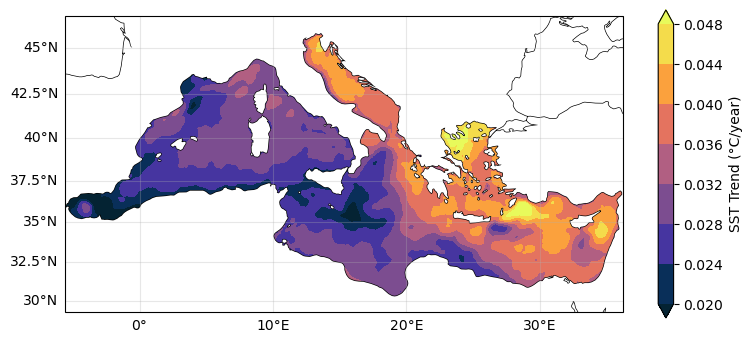

In [ ]:
fig, ax0 = plt.subplots(figsize=(9, 4), subplot_kw={'projection': ccrs.Mercator()})

clevs = np.arange(0.02, 0.05, 0.004)

pcm_harmonics = ax0.contourf(
    harmonics['lon'], harmonics['lat'], harmonics['slope'], clevs,
    cmap=cmocean.cm.thermal, extend="both", transform=ccrs.PlateCarree()
)
ax0.add_feature(cfeature.LAND, facecolor='white', zorder=2)
ax0.coastlines()
add_gridlines(ax0)
# ax0.set_title('(a)', fontsize=10, loc = 'left')

cbar = fig.colorbar(pcm_harmonics, ax=ax0, orientation='vertical', label='SST Trend (°C/year)')
output_path = "/home/bfernandez/Escritorio/OSR10/figures/"
plt.savefig(output_path + 'MED_trends_2reg.png', bbox_inches="tight", dpi=500)  # Save with high resolution

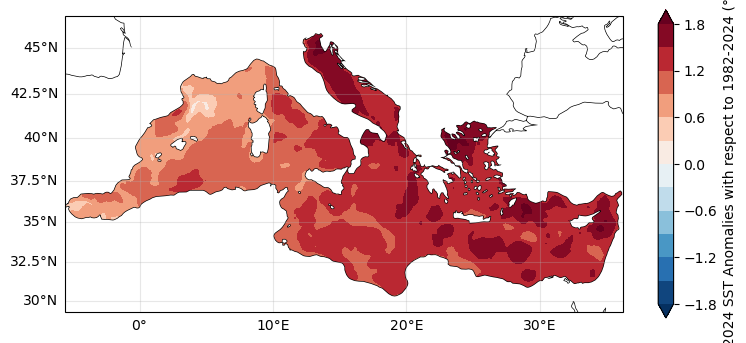

In [ ]:
fig, ax0 = plt.subplots(figsize=(9, 4), subplot_kw={'projection': ccrs.Mercator()})

clevs = np.arange(-1.8, 1.9, 0.3)

coolwarm = mpl.cm.RdBu_r

pcm_harmonics = ax0.contourf(
    anomalies['lon'], anomalies['lat'], anomalies, clevs,
    cmap=coolwarm, extend="both", transform=ccrs.PlateCarree()
)
ax0.add_feature(cfeature.LAND, facecolor='white', zorder=2)
ax0.coastlines()
add_gridlines(ax0)
# ax0.set_title('(a)', fontsize=10, loc = 'left')

cbar = fig.colorbar(pcm_harmonics, ax=ax0, orientation='vertical', label='2024 SST Anomalies with respect to 1982-2024 (°C)')
output_path = "/home/bfernandez/Escritorio/OSR10/figures/"
plt.savefig(output_path + 'MED_anomalies.png', bbox_inches="tight", dpi=500)  # Save with high resolution

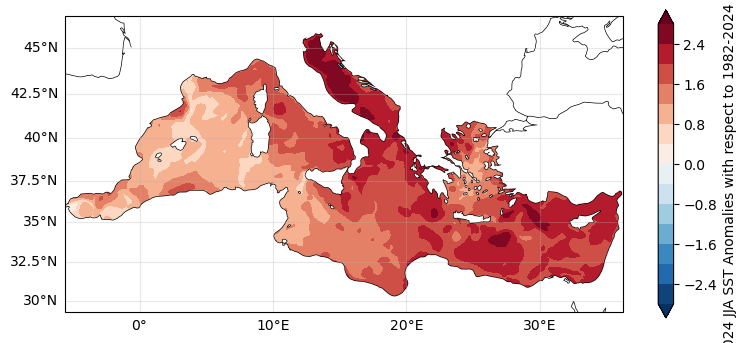

In [ ]:
fig, ax0 = plt.subplots(figsize=(9, 4), subplot_kw={'projection': ccrs.Mercator()})

clevs = np.arange(-2.8, 2.9, 0.4)

coolwarm = mpl.cm.RdBu_r

pcm_harmonics = ax0.contourf(
    anomalies_jja['lon'], anomalies_jja['lat'], anomalies_jja, clevs,
    cmap=coolwarm, extend="both", transform=ccrs.PlateCarree()
)
ax0.add_feature(cfeature.LAND, facecolor='white', zorder=2)
ax0.coastlines()
add_gridlines(ax0)
# ax0.set_title('(a)', fontsize=10, loc = 'left')

cbar = fig.colorbar(pcm_harmonics, ax=ax0, orientation='vertical', label='2024 JJA SST Anomalies with respect to 1982-2024 (°C)')
output_path = "/home/bfernandez/Escritorio/OSR10/figures/"
plt.savefig(output_path + 'MED_anomalies_jja.png', bbox_inches="tight", dpi=500)  # Save with high resolution

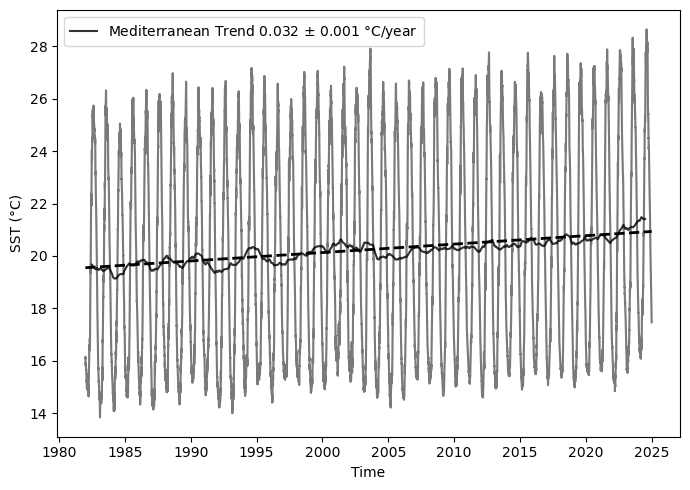

In [ ]:
# Create a standalone figure for ax2
fig, ax2 = plt.subplots(figsize=(7, 5))
w_sst = btools.weighted_mean(sst)
# Plot the global time series
ax2.plot(weighted_mean_sst.time, weighted_mean_sst,
         label=f'Mediterranean Trend {avg_slope_w*365.25:.3f} $\pm$ {avg_se_w*365.25:.3f} °C/year',
         color='k', alpha=0.8)
ax2.plot(w_sst.time, w_sst,
         color='k', alpha=0.4)

# ax2.fill_between(
#     weighted_mean_sst.time,
#     weighted_mean_sst - weighted_mean_error, weighted_mean_sst + weighted_mean_error,
#     color='k', alpha=0.2
# )
ax2.plot(weighted_mean_sst.time, trend_line_w, linestyle='--', linewidth=2, color='k', zorder=3)
ax2.plot(sst_spatial_mean.time, sst_spatial_mean, color='k', alpha=0.2)

# Set labels, legend, and title
ax2.set_xlabel('Time')
ax2.set_ylabel('SST (°C)')
ax2.legend()
# ax2.set_title('Global Time Series')

# Save the standalone plot
output_path = "/home/bfernandez/Escritorio/OSR10/figures/"
plt.tight_layout()
plt.savefig(output_path + 'MED_trends_ax2_2reg_enero2026.png', bbox_inches="tight", dpi=500)
plt.show()

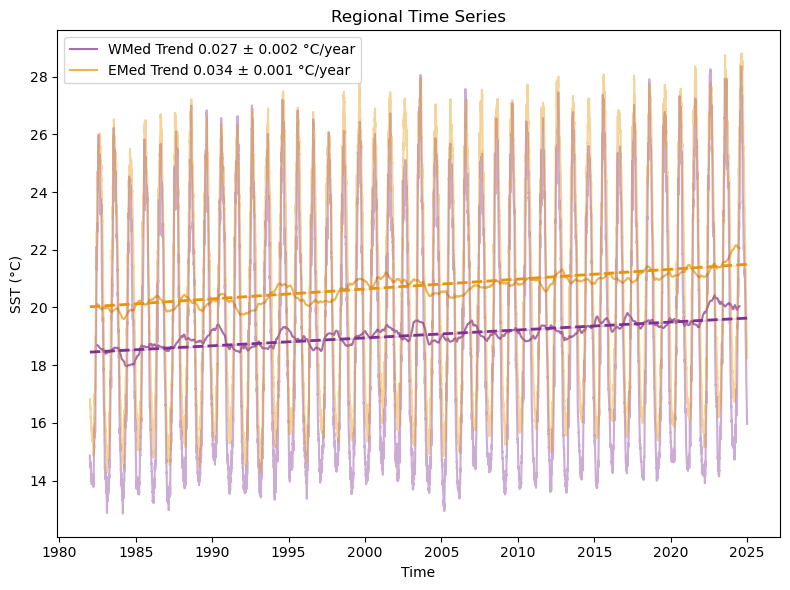

In [ ]:
# Create a standalone figure for ax3
fig, ax3 = plt.subplots(figsize=(8, 6))

# Plot the regional time series using the precomputed region_stats
plot_regions(ax3, region_stats_new, dss_err, region_colors)

ax3.plot(btools.weighted_mean(dss_with_new_merge['WEST_MED']).time, btools.weighted_mean(dss_with_new_merge['WEST_MED']),
         color=region_colors["WEST_MED"], alpha=0.4)
ax3.plot(btools.weighted_mean(dss_with_new_merge['EAST_MED']).time, btools.weighted_mean(dss_with_new_merge['EAST_MED']),
         color=region_colors["EAST_MED"], alpha=0.4)
# Set labels and title
ax3.set_xlabel('Time')
ax3.set_ylabel('SST (°C)')
ax3.set_title('Regional Time Series')

# Save the standalone plot
output_path = "/home/bfernandez/Escritorio/OSR10/figures/"
plt.tight_layout()
plt.savefig(output_path + 'MED_trends_ax3_2reg_enero2026.png', bbox_inches="tight", dpi=500)
plt.show()

## Figure 1

/tmp/ipykernel_398887/2003478571.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


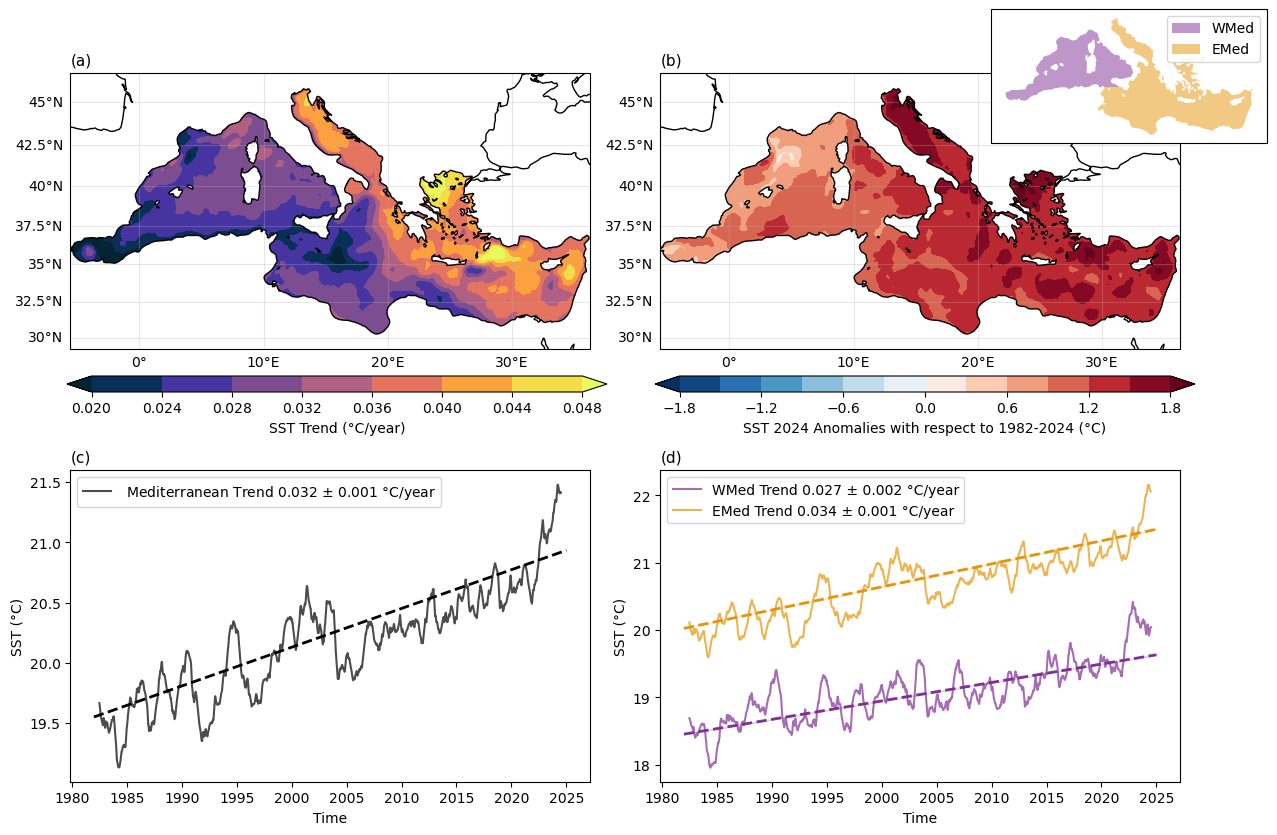

In [ ]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)

for ax in axs.flat:
    ax.set_visible(False)

# (a) First subplot: SST Trend map
ax0 = plt.subplot(gs[0, 0], projection=ccrs.Mercator())
clevs = np.arange(0.02, 0.05, 0.004)
pcm = ax0.contourf(
    harmonics['lon'], harmonics['lat'], harmonics['slope'], clevs,
    cmap=cmocean.cm.thermal, extend="both", transform=ccrs.PlateCarree()
    )   
setup_map(ax0)
ax0.set_title('(a)', fontsize=11, loc='left')
cbar_ax = fig.add_axes([0.06, 0.56, 0.45, 0.02]) 
fig.colorbar(pcm, ax=ax0, cax=cbar_ax, orientation='horizontal', label='SST Trend (°C/year)', shrink=0.7)
pos_ax0 = ax0.get_position()
pos_cbar_ax = cbar_ax.get_position()
ax0.set_position([pos_ax0.x0, pos_cbar_ax.y0 - pos_cbar_ax.height - 0.07, pos_ax0.width, pos_ax0.height])
# # (b) Second subplot: Regional boundaries
# ax1 = plt.subplot(2, 2, 2, projection=ccrs.Mercator())
# setup_map(ax1)
# num_regions = len(locations)
# region_colors = dict(zip(locations.keys(), sns.color_palette("CMRmap", num_regions)))  # Assign colors for each region
# for region, areas in locations.items():
#     for i, area in enumerate(areas):
#         lat_min, lat_max = area['lat'].start, area['lat'].stop
#         lon_min, lon_max = area['lon'].start, area['lon'].stop
#         lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
#         lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
#         ax1.fill(
#             lons, lats, color=region_colors[region], alpha=0.5, edgecolor='none',
#             label=region if i == 0 else "", transform=ccrs.PlateCarree()
#         )

# ax1.set_title('(b) Placeholder for future content')
# ax1.legend(loc="upper right", title="Sub-Regions")
ax4 = plt.subplot(gs[0, 1], projection=ccrs.Mercator())
clevs = np.arange(-1.8, 1.9, 0.3)
coolwarm = mpl.cm.RdBu_r
pcm_anomalies = ax4.contourf(
    anomalies['lon'], anomalies['lat'], anomalies, clevs,
    cmap=coolwarm, extend="both", transform=ccrs.PlateCarree()
)
setup_map(ax4)
ax4.set_title('(b)', fontsize=11, loc='left')
cbar_ax4 = fig.add_axes([0.55, 0.56, 0.45, 0.02]) 
fig.colorbar(pcm_anomalies, ax=ax4, cax=cbar_ax4, orientation='horizontal', label='SST 2024 Anomalies with respect to 1982-2024 (°C)', shrink=0.7)
pos_ax4 = ax4.get_position()
pos_cbar_ax4 = cbar_ax4.get_position()
ax4.set_position([pos_ax4.x0, pos_cbar_ax4.y0 - pos_cbar_ax4.height - 0.07, pos_ax4.width, pos_ax4.height])
# ax0.set_title('(a)', fontsize=10, loc = 'left')

# (b) Second subplot: Regional boundaries (Inset of ax0)
left, bottom, width, height = [0.83, 0.83, 0.23, 0.25]  # Adjust as needed to place the inset inside the main plot
ax1 = fig.add_axes([left, bottom, width, height], projection=ccrs.Mercator())
ax1.add_feature(cfeature.LAND, facecolor='white', zorder=2)
ax1.coastlines(color='white', zorder=2)
# setup_map(ax1, coords=False)
num_regions = len(locations)
region_colors = dict(zip(locations.keys(), sns.color_palette("CMRmap", num_regions)))  # Assign colors for each region
region_labels = {"WEST_MED": "WMed", "CENTRAL_MED": "CMed", "EAST_MED": "EMed"}
for region, areas in locations.items():
    for i, area in enumerate(areas):
        lat_min, lat_max = area['lat'].start, area['lat'].stop
        lon_min, lon_max = area['lon'].start, area['lon'].stop
        lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
        lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
        ax1.fill(
            lons, lats, color=region_colors[region], alpha=0.5, edgecolor='none',
            label=region_labels.get(region, region) if i == 0 else "", transform=ccrs.PlateCarree()
        )

ax1.legend(loc="upper right")

# (c) Third subplot: Global time series plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(weighted_mean_sst.time, weighted_mean_sst,
        label=f' Mediterranean Trend {avg_slope_w*365.25:.3f} $\pm$ {avg_se_w*365.25:.3f} °C/year',
        color='k', alpha=0.7
        )
# ax2.fill_between(
#     weighted_mean_sst.time,
#     weighted_mean_sst - se_sst, weighted_mean_sst + se_sst,
#     color='k', alpha=0.2
#     )
ax2.plot(weighted_mean_sst.time, trend_line_w, linestyle='--', linewidth=2, color='k', zorder=3)
ax2.set_xlabel('Time')
ax2.set_ylabel('SST (°C)')
ax2.legend()
ax2.set_title('(c)', fontsize=11, loc='left')

# (d) Fourth subplot: Regional time series
ax3 = fig.add_subplot(gs[1, 1])
plot_regions(ax3, region_stats, dss_err, region_colors)
ax3.set_title('(d)', fontsize=11, loc='left')  # Panel label


plt.tight_layout()
output_path = "/home/bfernandez/Escritorio/OSR10/figures/"
plt.savefig(output_path + 'MED_trends_combined_2reg_new_anomalies.png', bbox_inches="tight", dpi=500)
plt.savefig(output_path + 'MED_trends_combined_2reg_new_anomalies.pdf', bbox_inches="tight", dpi=500)
plt.show()

### WE LOAD THE MHW data

The data is stored in a dictionary format where the metrics are nested in the baselines

In [ ]:
dss = {}
for baseline_type in baselines:
    baseline_years = 20
    if baseline_type == "detrended_baseline":
        fold = f"{root_fold}/detrended/fixed_baseline_30_year"  # Folder path for detrended baseline
    elif baseline_type == "fixed_baseline":
        fold = f"{root_fold}/{baseline_type}_30_year/"
    else:
        fold = f"{root_fold}/{baseline_type}_{baseline_years}_year/"
    
    dss[baseline_type] = xr.open_mfdataset(f"{fold}/*.nc", combine="by_coords").compute()
    dss[baseline_type] = dss[baseline_type] .sel(time=slice(2002, 2024))

In [ ]:
dss = {}
for baseline_type in baselines:
    baseline_years = 20
    if baseline_type == "detrended_baseline":
        fold = f"{root_fold}/detrended/fixed_baseline_30_year"  # Folder path for detrended baseline
    elif baseline_type == "fixed_baseline":
        fold = f"{root_fold}/{baseline_type}_30_year/"
    else:
        fold = f"{root_fold}/{baseline_type}_{baseline_years}_year/"
    
    dss[baseline_type] = xr.open_mfdataset(f"{fold}/*.nc", combine="by_coords").compute()
    dss[baseline_type] = dss[baseline_type] .sel(time=slice(2002, 2024))

In [ ]:
def merge_boxes(ds, coord_slices):
    """
    Return ds cropped to the union of all lat/lon slices in coord_slices.
    Drops the region dimension entirely.
    """
    masks = []
    for coords in coord_slices:
        lat0, lat1 = coords['lat'].start, coords['lat'].stop
        lon0, lon1 = coords['lon'].start, coords['lon'].stop

        mask = ((ds.lat >= lat0) & (ds.lat <= lat1) &
                (ds.lon >= lon0) & (ds.lon <= lon1))
        masks.append(mask)

    # OR together all box‑masks (stack→any) to get a single union mask:
    union_mask = xr.concat(masks, dim="box").any(dim="box")

    # apply it and drop all points outside:
    ds_union = ds.where(union_mask, drop=True)

    # finally drop the region dim if present:
    return ds_union.drop_vars('region', errors='ignore')


# 2) Main loader that applies the above to your `dss` + `locations`
def load_baseline_data_for_regions(dss, locations):
    """
    Inputs:
      - dss:    dict of {baseline_type: xarray.Dataset(region, time, lat, lon, …)}
      - locations: dict of {loc_name: [ {lat:slice, lon:slice}, … ]}

    Returns:
      - out:    dict of {baseline_type: {loc_name: xr.Dataset(time, lat, lon, metrics…)}}
    """
    out = {}
    for baseline_type, ds in dss.items():
        out[baseline_type] = {}
        for loc, boxes in locations.items():
            ds_union = merge_boxes(ds, boxes)
            out[baseline_type][loc] = ds_union
    return out

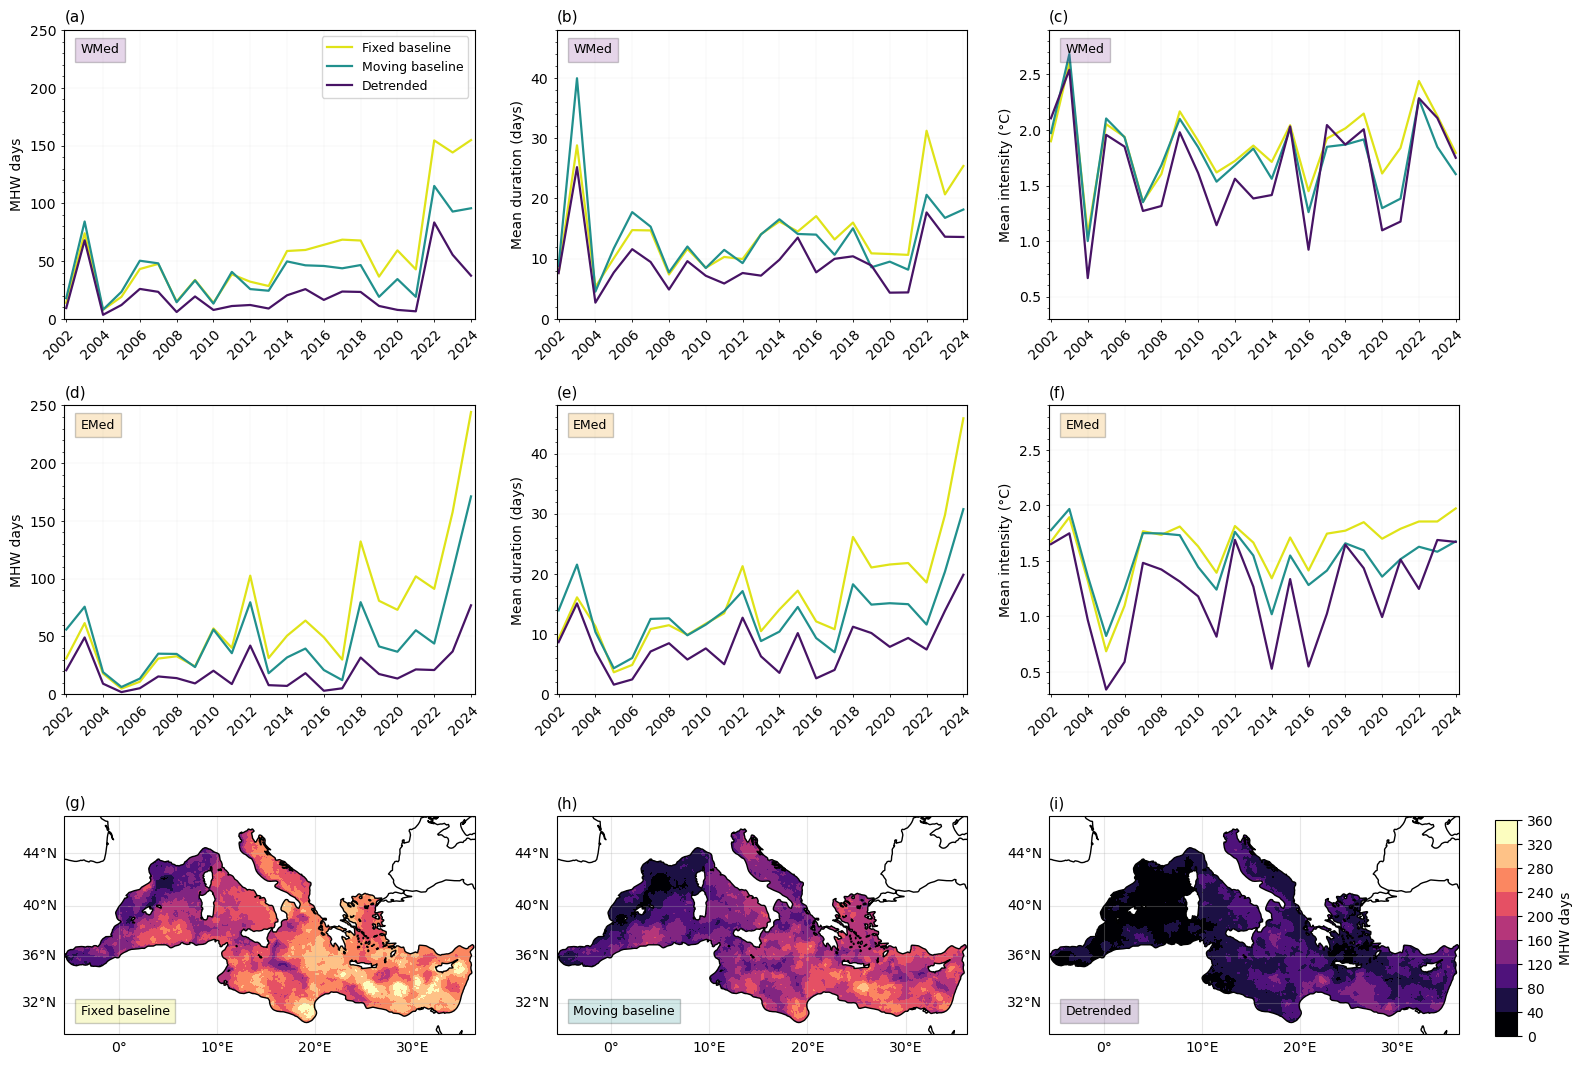

In [ ]:
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator

# ——— parameters & palettes ———
metrics       = ["MHW", "mean_duration", "mean_anomaly"]
labels        = ["MHW days", "Mean duration (days)", r"Mean intensity (°C)"]
region_labels = {"WEST_MED": "WMed", "EAST_MED": "EMed"}
baselines     = ["fixed_baseline", "moving_baseline", "detrended_baseline"]
legend_labels = {
    "fixed_baseline":     "Fixed baseline",
    "moving_baseline":    "Moving baseline",
    "detrended_baseline": "Detrended"
}
panels        = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]

# line colors for timeseries
cmap_ts      = mpl.colormaps["viridis_r"]
colors_lines = [cmap_ts(x) for x in (0.05, 0.5, 0.95)]

# one color per region (for text boxes)
region_colors = dict(zip(
    locations.keys(),
    sns.color_palette("CMRmap", len(locations))
))

# contour‐map settings
clevs   = np.arange(0, 361, 40)
cmapMap = mpl.cm.magma
norm    = mpl.colors.BoundaryNorm(clevs, cmapMap.N)
fs = np.sqrt(8) + 0.4

# Define y-axis limits for each metric
ylims = {
    "MHW": (0, 250),
    "mean_duration": (0, 48),
    "mean_anomaly": (0.3, 2.9)
}



# ——— figure setup ———
nrows = len(locations) + 1
ncols = len(metrics)

fig = plt.figure(figsize=(6 * ncols, 4.5 * nrows))
gs = gridspec.GridSpec(nrows, ncols)

axs = np.empty((nrows, ncols), dtype=object)
for i in range(nrows):
    for j in range(ncols):
        if i < nrows - 1:
            axs[i, j] = fig.add_subplot(gs[i, j])
        else:
            axs[i, j] = fig.add_subplot(gs[i, j], projection=ccrs.Mercator())


# ——— load & precompute time series ———
region_baseline_dss = load_baseline_data_for_regions(dss, locations)

time_series = {
    baseline: {
        loc: {
            metric: btools.weighted_mean(
                        region_baseline_dss[baseline][loc][metric]
            )
            for metric in metrics
        }
        for loc in locations
    }
    for baseline in baselines
}


# ——— TOP ROWS: time‐series per region & metric ———
for i, loc in enumerate(locations):
    for j, (metric, ylabel, panel) in enumerate(zip(metrics, labels, panels)):
        ax = axs[i, j]
        for k, baseline in enumerate(baselines):
            ts = time_series[baseline][loc][metric]
            ax.plot(
                ts.time.values, ts.values,
                color=colors_lines[k],
                label=legend_labels[baseline],
                linewidth=1.6
            )

        ax.set_ylabel(ylabel, fontsize=10)
           # Set x-axis range and ticks
        ax.set_xlim([2001.9, 2024.2])
        ax.set_xticks(list(range(2002, 2025, 2)))
        ax.set_ylim(ylims[metric])
        
        # Add grid
        ax.grid(which="major", linewidth=fs * 0.02)
        
        # Configure tick parameters
        ax.tick_params(axis="both", which="major", labelsize=10, size=fs * 0.75, width=fs * 0.18)
        ax.tick_params(axis="x", which="minor", length=fs * 1.2, width=fs * 0.12, color="gray", labelsize=10)
        ax.tick_params(axis="y", which="minor", length=fs * 0.9, width=fs * 0.12, color="k", labelsize=10)
        
        # Minor tick settings
        ax.xaxis.set_tick_params(which="minor", bottom=True)
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_tick_params(which="minor", left=True, size=fs * 0.5, width=fs * 0.15)
        
        # Rotate x-tick labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        ax.tick_params(labelsize=10)
        panel_idx = i * ncols + j
        ax.set_title(panels[panel_idx], loc="left", fontsize=11)
        if j == 0 and i== 0:
            ax.legend(fontsize=9)
        ax.text(
            0.04, 0.92, region_labels[loc],
            transform=ax.transAxes,
            bbox=dict(facecolor=region_colors[loc], alpha=0.2),
            fontsize=9
        )


# ——— BOTTOM ROW: Cartopy contour maps ———
selected_year = 2024
for j, baseline in enumerate(baselines):
    # re-create this subplot as a Cartopy axis
    ax = axs[-1, j]

    # land & coastlines
    ax.add_feature(cfeature.LAND,   facecolor="white", zorder=2)
    ax.coastlines(zorder=3)

    # pull MHW field & mask that one bad grid‐point
    ds_year = dss[baseline]["MHW"].sel(time=selected_year, method="nearest")
    # lon2d, lat2d = np.meshgrid(ds_year.lon, ds_year.lat)
    # mask = (np.isclose(lon2d, lon_val) & np.isclose(lat2d, lat_val))
    # ds_year = ds_year.where(~mask, np.nan)

    # filled contours
    im = ax.contourf(
        ds_year.lon, ds_year.lat, ds_year,
        clevs,
        transform=ccrs.PlateCarree(),
        cmap=cmapMap, norm=norm,
        zorder=0
    )

    # gridlines w/ only left & bottom labels
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.ylocator     = mpl.ticker.FixedLocator(np.arange(32, 46, 4))
    gl.top_labels   = False
    gl.right_labels = False

    ax.set_title(f"{panels[j+6]}", loc="left", fontsize=11)
    # panel‐label box
    ax.text(
        0.04, 0.09,
        f"{legend_labels[baseline]}",
        transform=ax.transAxes,
        bbox=dict(facecolor=colors_lines[j],
                  alpha=0.2),
        fontsize=9
    )

# colorbar
cbar_ax = fig.add_axes([0.92, 0.135, 0.012, 0.16])  # [left, bottom, width, height] in figure coordinates
plt.colorbar(im, cax=cbar_ax, orientation="vertical", label="MHW days")
plt.subplots_adjust(hspace=0.3)
# Save the figure
savepath = f"{savefold}/MHW_Metrics_byREGION_maps_new_new.png"
plt.savefig(savepath, dpi=500, bbox_inches="tight")
plt.show()